In [17]:
element_file = pd.read_csv('57Co.csv', error_bad_lines=False)
print(element_file[' energy [keV] '].iloc[-1])
element_file[' energy [keV] '][1:]

11291.5


b'Skipping line 25: expected 31 fields, saw 32\n'


1       1223.980
2       1377.663
3       1504.826
4       1689.600
5       1757.606
         ...    
214     9755.000
215    10077.100
216    10294.400
217    11070.100
218    11291.500
Name:  energy [keV] , Length: 218, dtype: float64

In [22]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import quad
from scipy.optimize import curve_fit






def z_1d( E, T ):
    '''First derivative of the partition function'''
    
    suma = 0
    
    for e in E:
        suma += e * np.exp(-e/T)
        
    return suma


############################################################################################################ 


def g_1d(E, T, a, P_N, P_Z):
    '''Definition of the first derivative of the first function with respect to E'''
    
    U = E - P_N - P_Z
    
    g = (np.sqrt(np.pi)/12.) * ( (2. * np.sqrt(a * U))/( a**(0.25) * U**(1.25)) )
    
    return E*np.exp(-E/T) *  g


#############################################################################################################



def g_2d(E, T, sigma, E_0, tau):
    '''Definition of the first derivative of the second function with respect to E'''
    
    g = ( (np.sqrt(2. * np.pi) * sigma) / tau ) * (np.exp(E - E_0)/tau )
    
    return  E*np.exp(-E/T) * g 

    
#############################################################################################################    




def z_1(E, T):
    '''First term of the partition function'''
    
    suma = 0
    
    for e in E:
        suma += np.exp(-e/T)
        
    return suma
  
############################################################################################################ 






def g_1(E, T, a, P_Z, P_N):
    '''Definition of the first density function'''
    
    U = E - P_N - P_Z
    
    g = (np.sqrt(np.pi)/12.) * ( (2. * np.sqrt(a * U))/( a**(0.25) * U**(1.25) ) ) 
    
    return np.exp(-E/T) * g
    
#############################################################################################################   






def g_2(E, T, sigma, E_0, tau):
    '''Definition of the second density function'''
    
    g = ( (np.sqrt(2. * np.pi) * sigma) / tau ) * (np.exp(E - E_0)/tau )
    
    return np.exp(-E/T) * g
    
#############################################################################################################  





def binding(P, T, alfa, beta, gamma, eta, delta):
    '''Binding energy function - Semiempirical mass formula'''

    N , Z = P
    
    A = N + Z
    t = (0.5) * (Z - N)
    R = 1.07 * (1 + 0.01 * T)
    
    
    f = A%2 + Z%2 - np.ones(len(A)) 
    
    return alfa * A**(3/4) + beta * A**(2/3) + (gamma - (eta/A**(1/3)))*( (4*t**2 + 4*np.abs(t))/A ) + (Z**2)/(R * A**(1/3))*(1 - 0.7636/(Z**(2/3)) - 2.29/(R * A**(1/3))**2) + delta*(f/A**(3/4))
    

############################################################################################################ 



'''Temperature in MeV (1, 4)'''
T = np.linspace(1, 4, 10)


'''A list of Y values is created to organized the total energy: Excitation Energy + Binding Energy(T=0) 
for all ts'''

Y = []

for t in T:
    t = np.round(t, 2)
   

    '''Properties of the nuclei
       [B_0, P(Z), P(N), a, E_0, sigma, N, Z, tau]'''
    
    
    
    '''For light nuclei'''
    light_nuclei = {'22Na' : [7.91, 0, 0, 3.13, -2.00, 1.9, 11, 11, 2.23], '23Na' : [8.11, 0, 2.67, 3.68, -0.40, 2.0, 12, 11, 2.68],
                    '25Na' : [8.10, 0, 1.80, 4.03, -0.70, 2.1, 14, 11, 1.91], '24Mg' : [8.25, 2.46, 2.67, 3.32, 2.80, 2.0, 12, 12, 2.18], '25Mg' : [8.22, 2.46, 0, 3.85, -1.00, 2.15, 13, 12, 2.12],
                    '26Mg' : [8.33, 2.46, 1.80, 4.08, 0.50, 2.25, 14, 12, 2.07], '27Mg' : [8.26, 2.46, 0, 4.00, -0.80, 2.25, 15, 12, 2.04], '26Al' : [8.15, 0, 0, 3.65, -1.80, 2.0, 13, 13, 1.95],
                    '27Al' : [8.33, 0, 1.80, 3.45, -0.35, 2.0, 14, 13, 2.08], '28Al': [8.31, 0, 0, 0, -0.70, 2.2, 15, 13, 1.50], '29Al' : [8.35, 0, 1.67, 4.08, -0.65, 2.2, 16, 13, 1.88],
                    '28Si' : [8.45, 2.09, 1.80, 3.05, 3.20, 2.0, 14, 14, 2.09], '29Si' : [8.45, 2.09, 0, 3.57, 0.75, 2.1, 15, 14, 1.91], '30Si' : [8.52, 2.09, 1.67, 3.81, 1.10, 2.25, 16, 14, 2.04],
                    '31Si' : [8.46, 2.09, 0, 4.05, 0.40, 2.15, 17, 14, 1.79], '30P' : [8.35, 0, 0, 3.47, -1.00, 1.9, 15, 15, 1.89], '31P' : [8.48, 0, 1.67, 3.87, 0.40, 2.0, 16, 15, 1.78],
                    '32P' : [8.46, 0, 0, 3.45, -1.75, 2.0, 17, 15, 1.96], '32S' : [8.49, 1.62, 1.67, 3.39, 1.75, 2.0, 16, 16, 2.05], '33S' : [8.50, 1.62, 0, 4.36, 0.0, 2.2, 17, 16, 1.68],
                    '34S' : [8.58, 1.62, 1.86, 4.12, 1.84, 2.2, 18, 16, 1.77], '34Cl' : [8.40, 0, 0, 3.72, -1.61, 2.15, 17, 17, 1.92], '35Cl' : [8.52, 0, 1.86, 4.11, 0.31, 2.2, 18, 17, 1.76],
                    '37Cl' : [8.57, 0, 2.04, 4.88, 1.15, 2.1, 20, 17, 1.40], '38Cl' : [8.50, 0, 0, 5.41, -0.99, 2.2, 21, 17, 1.31],
                    '36Ar': [8.52, 1.62, 1.86, 4.03, 2.46, 2.1, 18, 18, 1.69], '37Ar' : [8.53, 1.62, 0, 4.41, -0.34, 2.35, 19, 18, 1.73], '38Ar' : [8.61, 1.62, 2.04, 4.80, 0.91, 2.5, 20, 18, 1.73],
                    '39Ar': [8.56, 1.62, 0, 5.34, -0.04, 2.4, 21, 18, 1.44], '40Ar' : [8.59, 1.62, 1.64, 6.70, 1.00, 2.65, 22, 18, 1.28], '41Ar' : [8.53, 1.62, 0, 5.74, -0.50, 2.55, 23, 18, 1.43],
                    '38K' : [8.44, 0, 0, 4.29, -0.94, 2.15, 19, 19, 1.59], '39K' : [8.56, 0, 2.04, 4.68, 0.95, 2.2, 20, 19, 1.50], '40K' : [8.54, 0, 0, 5.34, -0.90, 2.2, 21, 19, 1.31], 
                    '41K' : [8.58, 0, 1.64, 5.78, -1.48, 2.7, 19, 22, 1.55], '42K' : [8.55, 0, 0, 5.56, -2.27, 2.6, 23, 19, 1.49], '41Ca' : [8.55, 1.83, 0, 5.44, -0.50, 2.5, 21, 20, 1.52],
                    '42Ca': [8.62, 1.83, 1.64, 6.58, 0.50, 2.75, 22, 20, 1.39], '43Ca': [8.60, 1.83, 0, 6.91, -1.45, 2.9, 23, 20, 1.37], '44Ca' : [8.66, 1.83, 1.44, 6.34, 0.30, 2.8, 24, 20 ,1.43],
                    '45Ca': [8.63, 1.83, 0, 7.11, -0.44, 2.75, 25, 20, 1.23], '41Sc': [8.37, 0, 2.04, 5.63, 0.20, 2.5, 20, 21, 1.41], '43Sc' : [8.53, 0, 1.64, 6.55, -0.61, 2.65, 22, 21, 1.31],
                    '44Sc' : [8.56, 0, 0, 6.97, -1.88, 2.65, 23, 21, 1.20], '45Sc' : [8.62, 0, 1.44, 7.59, -1.45, 2.9, 24, 21, 1.24], '46Sc' : [8.24, 0, 0, 6.33, -2.28, 2.75, 25, 21, 1.35],
                    '47Sc' : [8.66, 0, 1.54, 7.08, -1.10, 2.85, 26, 21, 1.28], '45Ti' : [8.55, 1.73, 0, 6.84,-0.83, 2.8, 23, 22, 1.30], '46Ti' : [8.66, 1.73, 1.44, 6.93, 1.14, 2.7, 24, 22, 1.23],
                    '47Ti' : [8.66, 1.73, 0, 5.97, -1.00, 2.8, 25, 22, 1.47], '48Ti' : [8.72, 1.73, 1.54, 6.93, 0.52, 2.85, 25, 22, 1.32], '49Ti' : [8.71, 1.73, 0 , 6.11, -0.83, 2.8, 27, 22, 1.30],
                    '47V' : [8.58, 0, 1.44, 6.79, -1.13, 2.8, 24, 23, 1.32], '48V' : [8.62, 0, 0, 6.77, -1.28, 2.6, 25, 23, 1.14], '49V' : [8.68, 0, 1.54, 6.76, -1.33, 2.9, 26, 23, 1.35],
                    '50V' : [8.69, 0, 0, 6.67, -1.48, 2.65, 27, 23, 1.19], '51V' : [8.74, 0, 1.30, 6.72, -0.15, 2.7, 28, 23, 1.18], '50Cr' : [8.70, 1.35, 1.54, 6.54, 0.43, 2.85, 26, 24, 1.34],
                    '51Cr': [8.71, 1.35, 0, 6.44, -0.78, 2.8, 27, 24, 1.32], '52Cr' : [8.77, 1.35, 0, 6.15, 0.02, 2.9, 28, 24, 1.43], '53Cr' : [8.76, 1.35, 0, 5.88, -0.65, 2.8, 29, 24, 1.40],
                    '54Cr': [8.78, 1.35, 1.27, 6.96, 0.65, 2.9, 30, 24, 1.24], '55Cr' : [8.73, 1.35, 0, 7.52, -0.47, 2.9, 31, 24, 1.13], '51Mn' : [8.63, 0, 1.54, 6.29, 0.26, 2.6, 26, 25, 1.22],
                    '52Mn': [8.67, 0, 0, 6.29, 0.26, 2.6, 27, 25, 1.22], '53Mn' : [8.73, 0, 1.30, 5.87, 0.50, 2.45, 28, 25, 1.21], '54Mn' : [8.74, 0, 0, 6.21, -1.49, 2.7, 29, 25, 1.27],
                    '55Mn': [8.76, 0, 1.27, 7.41, -0.50, 2.9, 30, 25, 1.14], '56Mn' : [8.74, 0, 0, 7.41, -0.50, 2.9, 31, 25, 1.14], '54Fe': [8.74, 1.54, 1.30, 6.13, 0.60, 2.9, 28, 26, 1.39],
                    '55Fe': [8.75, 1.54, 0, 5.76, -1.25, 3.0, 29, 26, 1.53], '56Fe' : [8.79, 1.54, 1.27, 6.75, 0.80, 2.9, 30, 26, 1.26], '57Fe' : [8.77, 1.54, 0, 6.91, -1.60, 3.2, 31, 26, 1.37],
                    '58Fe': [8.79, 1.54, 1.29, 7.65, 0.60, 3.05, 32, 26, 1.17], '59Fe' : [8.75, 1.54, 0, 7.33, -1.20, 3.15, 33, 26, 1.27], '56Co' : [8.69, 0, 0, 5.51, -0.96, 2.6, 29, 27, 1.31],
                    '57Co': [8.74, 0, 1.27, 5.95, 0.05, 2.7, 30, 27, 1.27], '59Co' : [8.77, 0, 1.29, 8.04, -0.40, 3.0, 32, 27, 1.06], '60Co' : [8.75, 0, 0, 7.23, -1.56, 2.9, 33, 27, 1.14],
                    '58Ni': [8.73, 1.20, 1.27, 5.44, -0.17, 2.95, 30, 28, 1.59], '59Ni' : [8.74, 1.20, 0, 5.97, -1.75, 3.1, 31, 28, 1.51], '60Ni' : [8.78, 1.20, 1.29, 6.54, 0.01, 3.05, 32, 28, 1.36],
                    '61Ni': [8.76, 1.20, 0, 6.94, -1.25, 3.1, 33, 28, 1.29], '62Ni' : [8.79, 1.20, 1.41, 7.59, 0.77, 3.0, 34, 28, 1.13], '64Ni' : [8.78, 1.20, 1.50, 8.52, 1.20, 3.0, 36, 28, 0.99],
                    '62Cu': [8.72, 0, 0, 7.19, -1.00, 2.75, 33, 29, 1.06], '63Cu' : [8.75, 0, 1.41, 8.88, -0.25, 3.1, 34, 29, 0.98], '64Cu' : [8.74, 0, 0, 8.09, -1.25, 2.9, 35, 29, 0.995],
                    '65Cu': [8.76, 0, 1.50, 8.70, 0.03, 3.05, 36, 29, 0.97], '66Cu' : [8.73, 0, 0, 8.33, -1.02, 2.9, 37, 29, 0.94]}
    
    
    '''It contains the values for a particular t for light nuclei'''
    y_l = []  
    
    for el_l in light_nuclei:
        
        
        '''We convert to float and remove the NaN terms'''
        
        element_file = pd.read_csv(el_l+'.csv', error_bad_lines=False)
    
        element_file[' energy [keV] '] = pd.to_numeric(element_file[' energy [keV] '], errors='coerce')
    
        element_file.dropna(subset = [' energy [keV] '], inplace=True) 
    
        
        '''We see which density formula is to be used'''
        
        U_x = 2.5 + (150./( light_nuclei[el_l][6] + light_nuclei[el_l][7] ))
            
        E_x = (U_x + light_nuclei[el_l][1] + light_nuclei[el_l][2])
        
        '''[B_0, P(Z), P(N), a, E_0, sigma, N, Z, tau]'''
        
        
        if (element_file[' energy [keV] '].iloc[-1]/1000) > E_x:
            #print(el_l+'(g(a))')
            #print('Cumple Primera')
            
            '''Data(E, T, a, P_Z, P_N)'''
            
            intr_0 = quad(g_1, element_file[' energy [keV] '].iloc[-1]/1000, element_file[' energy [keV] '].iloc[-1]/1000 + 10, 
                              args=(t, light_nuclei[el_l][3], light_nuclei[el_l][1], light_nuclei[el_l][2]))[0]
            
            intr_1 = quad(g_1d, element_file[' energy [keV] '].iloc[-1]/1000, element_file[' energy [keV] '].iloc[-1]/1000 + 10, 
                              args=(t, light_nuclei[el_l][3], light_nuclei[el_l][1], light_nuclei[el_l][2]))[0]
            
            print(intr_1)
            print(intr_0)
            
            print('\n')
            
        else:
            #print(el_l+r'(g($\tau$))')
            #print('Cumple Segunda')
            
            '''Data(E, T, sigma, E_0, tau)'''
            intr_0 = quad(g_2, element_file[' energy [keV] '].iloc[-1]/1000, E_x, 
                              args=(t, light_nuclei[el_l][5], light_nuclei[el_l][4], light_nuclei[el_l][8]))[0]
            
            intr_1 = quad(g_2d, element_file[' energy [keV] '].iloc[-1]/1000, E_x, 
                              args=(t, light_nuclei[el_l][5], light_nuclei[el_l][4], light_nuclei[el_l][8]))[0]
            
            print(intr_1)
            print(intr_0)
            
            print('\n')
            
           
            
        E_y = ( z_1d(element_file[' energy [keV] '][1:]/1000, t ) + intr_1 )/( 1.00 + z_1(element_file[' energy [keV] '][1:]/1000, t) + intr_0 )
            
            #print(E_y)
            #E_y = -(elements_pro[el][0])*(elements_pro[el][6] + elements_pro[el][7] ) + (1 / ( z_1( (element_file['energy'][2:]/1000), t) + intr_0) ) *  ( z_1d( (element_file['energy'][2:]/1000), t) + intr_1 )
            
        y_l.append( E_y  - light_nuclei[el_l][0] )
            
            
       
    Y.append(y_l)
       
    
    '''For heavy nuclei'''

    heavy_nuclei = {'63Zn' : [8.69, 1.06, 0, 7.45, -0.44, 3.0, 33, 30, 1.10] , '64Zn' : [8.73, 1.06, 1.41, 8.03, 0.99, 3.0, 34, 30, 1.04],  '65Zn' : [8.72, 1.06, 0, 8.57, -1.11, 3.2, 35, 30, 1.07],
                    '66Zn' : [8.75, 1.06, 1.50, 8.99, 1.50, 2.9, 36, 30, 0.89],   '67Zn' : [8.73, 1.06, 0, 9.39, -0.73, 3.2, 37, 30, 0.95], '68Zn' : [8.75, 1.06, 1.50, 9.75, 1.19, 3.1 , 38, 30, 0.88],
                    '69Ga' : [8.72, 0, 1.50, 10.21, 0.08, 3.15, 38, 31, 0.855], '71Ga' : [8.72, 0, 1.43, 10.76, 0.05, 3.2, 40, 31, 0.815], '70Ge' : [8.72, 1.36, 1.50, 10.74, 0.89, 3.35, 38, 32, 0.855],
                    '72Ge' : [8.73, 1.36, 1.43, 11.30, 0.88, 3.40, 40, 32, 0.845], '74Ge' : [8,72, 1.36, 1.88, 12.48, 0.84, 3.65, 42, 32, 0.83],'75As' : [8.70, 0, 1.88, 11.95, -1.24, 3.75, 42, 33, 0.92],
                    '75Se' : [8.68, 1.43 , 0, 12.02, -0.76, 3.55, 41, 34, 0.835],'76Se' : [8.71, 1.43, 1.88 , 12.11, 0.60, 3.75, 42, 34, 0.875],'77Se' : [8.69, 1.43, 0, 11.80, -0.68, 3.6, 43, 34, 0.84],
                    '78Se' : [8.72, 1.43, 1.47, 11.88, 0.94, 3.55, 44, 34, 0.82], '80Se' : [8.71, 1.43, 1.57, 11.89, 0.57, 3.70, 46, 34, 0.865],'79Br' : [8.69, 0, 1.47, 12.48, -0.98, 3.75, 44, 35, 0.835],
                    '84Kr' : [8.72, 1.17, 1.46, 11.36, 1.20, 3.45, 48, 36, 0.79 ],'83Rb' : [8.67, 0, 1.57, 12.70, -0.04, 3.55, 46, 37, 0.745],'85Sr': [8.67, 1.24, 0, 12.19, -0.01, 3.4, 47, 38, 0.725],
                    '92Zr' : [8.50, 1.20, 0.72, 11.17, 1.01, 3.35, 52, 40, 0.74 ],'94Zr' : [8.67, 1.20, 1.12, 12.15, 0.84, 3.65, 54, 40, 0.76 ], '93Nb': [8.66, 0, 0.72, 10.88, -0.12, 3.3, 52, 41, 0.745],
                    '93Mo' : [8.65, 1.28, 0, 10.13, 0.43, 3.3, 51, 42, 0.79],  '95Mo' : [8.65, 1.28, 0, 11.36, -0.87, 3.8, 53, 42, 0.87 ], '96Mo': [8.65, 1.28, 1.12, 12.67, 1.01, 3.7, 54, 42, 0.725],
                    '97Mo' : [8.63, 1.28, 0, 12.93, -0.01, 3.6, 55, 42, 0.70 ], '99Mo' : [8.61, 1.28, 0, 14.17, -0.66, 3.95, 57,42, 0.72],'101Mo': [8.57, 1.28, 0, 15.48, -0.51, 4.0, 59, 42, 0.66],
                    '99Ru' : [8.61, 1.28, 0, 12.68, -0.27, 3.8, 55, 44, 0.745], '100Ru': [8.62, 1.28, 1.29, 13.30, 0.95, 3.8, 56, 44, 0.725], '101Ru': [8.60, 1.28, 0, 13.93, -0.83, 4.0, 57, 44, 0.745],
                    '102Ru': [8.61, 1.28, 0.94, 15.13, 0.80, 3.85, 58, 44, 0.64], '103Rh': [8.58, 0, 0.94, 14.70, -0.36, 3.75, 58, 45, 0.64],'104Rh': [8.57, 0, 0, 15.30, -1.11, 3.75, 59, 45, 0.60],
                    '105Rh': [8.57, 0, 1.24, 16.06, -0.24, 3.95, 60, 45, 0.615],'104Pd': [8.58, 1.35, 0.94, 14.55, 0.90, 3.85, 58, 46, 0.655 ],'105Pd': [8.57, 1.35, 0, 15.16, -0.90, 4.2, 59, 46, 0.72],
                    '106Pd': [8.58, 1.35, 1.24, 15.64, 0.78, 4.1, 60, 46, 0.66],  '108Pd': [8.57, 1.35, 1.25, 17.01, 0.47, 4.3, 62, 46, 0.66 ], '107Ag': [8.55, 0, 1.18, 15.71, 0.08, 3.8, 60, 47, 0.59],
                    '108Ag': [8.54,    0,    0, 15.14, -0.76,3.6, 61, 47, 0.56],  '109Ag': [8.55, 0, 1.25, 16.80, -0.41, 4.1, 62, 47, 0.61 ],'111Ag': [8.53, 0, 1.14, 17.51, -0.31, 4.05, 64, 47, 0.575],
                    '108Cd': [8.55, 1.36, 1.24, 15.47, 1.20, 3.95, 60, 48, 0.625], '109Cd': [8.54, 1.36, 0, 16.12, -0.80, 4.25, 61, 48, 0.675 ],'110Cd':[8.55, 1.36, 1.25, 16.56, 0.95, 4.1, 62, 48, 0.62],
                    '111Cd': [8.54, 1.36, 0, 16.94, -0.39, 4.15, 63, 48, 0.615],'112Cd': [8.54, 1.36, 1.14, 15.82, 0.77, 4.15, 64, 48, 0.65], '114Cd':[8.54, 1.36, 1.32, 17.43, 0.59, 4.35, 66, 48, 0.635],
                    '115In': [8.52, 0, 1.14, 17.44, 0.15, 4.0, 66, 49, 0.55],  '117In':[8.50, 0, 1.15, 17.38, 0.11, 3.9, 68, 49, 0.535], '116Sn': [8.52, 1.19, 1.32, 14.90, 0.92, 4.15, 66, 50, 0.665],
                    '117Sn': [8.51, 1.19, 0, 16.70, 0.23, 3.9, 67, 50, 0.545], '118Sn':[8.52, 1.19, 0.94, 16.22, 1.16, 4.0, 68, 50, 0.58],'119Sn': [8.50, 1.19, 0, 18.01, 0.14, 4.0, 69, 50, 0.525],
                    '120Sn': [8.50, 1.19, 1.24, 16.57, 1.31, 4.0, 70, 50, 0.565], '123Te':[8.47, 1.14, 0, 17.81, -0.43, 4.35, 71, 52, 0.58], '124Te': [8.47, 1.14, 1.43, 16.81, 0.85, 4.35, 72, 52, 0.62],
                    '125Te': [8.46, 1.14, 0, 16.24, -0.85, 4.4, 73, 52, 0.66], '127I': [8.45, 0, 1.09, 16.92, -0.42, 4.3, 74, 53, 0.60], '129I': [8.44, 0, 1.20, 15.87, -0.45, 4.3, 76, 53, 0.64],
                    '131I': [8.42, 0, 1.04, 13.82, 0.11, 3.95, 78, 53, 0.63], '129Xe': [8.43, 1.12, 0, 17.68, -0.35, 4.25, 75, 54, 0.75], '131Xe': [8.42, 1.12, 0, 16.13, -0.49, 4.35, 77, 54, 0.63],
                    '132Xe': [8.43, 1.12, 1.04, 15.79, 0.89, 4.2, 78, 54, 0.605], '133Xe': [8.41, 1.12, 0, 13.68, 0.15, 3.95, 79, 54, 0.645], '131Cs': [8.42, 0, 1.20, 18.18, -0.52, 4.5, 76, 55, 0.585],
                    '134Cs': [8.40, 0, 0, 15.71, -0.63, 3.85, 79, 55, 0.53], '134Ba': [8.41, 1.58, 1.04, 17.38, 0.64, 4.6, 78, 56, 0.63], '136Ba': [8.40, 1.58, 0.70, 14.37, 1.07, 4.15, 80, 56, 0.645],
                    '138Ba': [8.39, 1.58, 0.85, 17.43, 1.07, 4.15, 82, 56, 0.715], '144Nd': [8.33, 1.18, 0.76, 16.35, 0.86, 4.25, 84, 60, 0.57], '150Nd': [8.23, 1.18, 1.10, 16.90, -0.01, 4.95, 90, 60, 0.595],
                    '147Pm': [8.28, 0, 0.92, 18.46, -0.22, 4.35, 86, 61, 0.525], '149Pm': [8.23, 0, 0.99, 20.09, -0.35, 4.60, 88, 61, 0.510], '151Pm': [8.24, 0, 1.10, 20.74, -0.18, 4.5, 90, 61, 0.495 ],
                    '148Sm': [8.28, 1.22, 0.92, 19.18, 0.70, 4.6, 86, 62, 0.54], '149Sm': [8.26, 1.22, 0, 19.85, -0.61, 4.80, 87, 62, 0.56], '150Sm': [8.26, 1.22, 0.99, 21.90, -0.08, 5.10, 88, 62, 0.555],
                    '151Sm': [8.24, 1.22, 0, 21.27, -0.94, 5.0, 89, 62, 0.56], '152Sm': [8.24, 1.22, 1.10, 22.85, -0.08, 5.2, 90, 62, 0.55], '154Sm': [8.23, 1.22, 0.92, 20.36, -0.05, 5.0, 90, 62, 0.58],
                    '149Eu': [8.25, 0, 0.92, 19.47, -0.13, 4.3, 86, 63, 0.495], '151Eu': [8.24, 0, 0.99, 21.13, -0.55, 4.7, 88, 63, 0.51], '153Eu': [8.23, 0, 1.10, 21.80,-0.64, 4.85, 90, 63 , 0.515],
                    '152Gd': [8.23, 0.97, 0.99, 21.45, 0.18, 4.8, 88, 64, 0.525], '153Gd': [8.22, 0.97, 0, 22.07, -0.81, 4.9, 89, 64, 0.515], '154Gd': [8.22, 0.97, 1.10, 22.12, 0.03, 4.9, 90, 64, 0.535],
                    '155Gd': [8.21, 0.97, 0, 21.75, -0.83, 4.9, 91, 64, 0.525], '156Gd': [8.22, 0.97, 0.92, 21.41, 0.48, 4.75, 92, 64, 0.495], '157Gd': [8.20, 0.97, 0, 21.92, -0.56, 4.85 ,93, 64, 0.50],
                    '158Gd': [8.20, 0.97, 0.73, 20.19, 0.60, 4.6, 94, 64, 0.49], '159Tb': [8.19, 0, 0.73, 20.54, -0.52, 4.6, 94, 65, 0.495], '161Tb': [8.17, 0, 0.70, 19.57, -0.29, 4.4 ,96, 65, 0.49],
                    '160Dy': [8.18, 0.92, 0.73, 21.19, 0.07, 4.8, 94, 66, 0.515], '161Dy': [8.17, 0.92, 0, 20.74, -0.74, 4.8, 95, 66, 0.53], '163Dy': [8.16, 0.92, 0, 21.62, -0.55, 4.85 , 97, 66, 0.50],
                    '164Dy': [8.16, 0.92, 0.87, 19.78, 0.43, 4.8, 98, 66, 0.525], '165Ho': [8.15, 0, 0.87, 20.24, -0.55, 4.8, 98, 67, 0.52], '166Ho': [8.13, 0, 0, 19.01, -0.85, 4.45, 99, 67, 0.485],
                    '163Er': [8.14, 0.62, 0, 22.31, -0.62, 4.7, 95, 68, 0.465], '165Er': [8.14, 0.62, 0, 21.41, -0.50, 4.7, 97, 68, 0.47], '166Er': [8.14, 0.62, 0.87, 20.95, -0.01, 4.85, 98, 68, 0.515],
                    '167Er': [8.13, 0.62, 0, 20.67, -0.39, 4.6, 99, 68, 0.47], '168Er': [8.13, 0.62, 0.61, 19.59, 0.10, 4.65, 100, 68, 0.505], '169Tm': [8.11, 0, 0.61, 20.96, -0.45, 4.6, 100, 69, 0.47],
                    '171Tm': [8.10, 0, 0.69, 20.17, -0.24, 4.5, 102, 69, 0.47], '169Yb': [8.10, 0.68, 0, 22.22, -0.55, 4.8, 99, 70, 0.455], '171Yb': [8.10, 0.68, 0, 21.28, -0.80, 5.0, 101, 70, 0.505],
                    '172Yb': [8.10, 0.68, 0.69, 19.59, 0.50, 4.5, 102, 70, 0.475], '177Yb': [8.05, 0.68, 0, 19.64, -0.58, 4.8, 107, 70, 0.515], '173Lu': [8.08, 0, 0.69, 21.79, -0.33, 4.65, 102, 71, 0.455],
                    '175Lu': [8.07, 0, 0.55, 21.22, -0.28, 4.5, 104, 71, 0.445], '177Lu': [8.05, 0, 0.40, 20.67, -0.34, 4.45, 106, 71, 0.44], '173Hf': [8.07, 0.64, 0, 22.80, -0.55, 4.8, 101, 72, 0.455],
                    '175Hf': [8.06, 0.64, 0, 22.23, -0.68, 4.9, 103, 72, 0.475], '177Hf': [8.05, 0.64, 0, 21.61, -0.15, 4.55, 105, 72, 0.43], '178Hf': [8.05, 0.64, 0.4, 19.24, 0.16, 4.55, 106, 72, 0.485],
                    '179Hf': [8.04, 0.64, 0, 20.26, -0.44, 4.75, 107, 72, 0.485],'180Hf': [8.03, 0.64, 0.73, 19.91, 0.36, 4.7, 108, 72, 0.485],'181Ta': [8.02, 0, 0.73, 21.26, -0.36, 4.8, 106, 73, 0.47],
                    '181W': [8.02, 0.72, 0, 21.70, -0.22, 4.65, 107, 74, 0.445], '182W': [8.02, 0.72, 0.73, 21.30, 0.44, 4.7, 108, 74, 0.46], '183W': [8.01, 0.72, 0, 20.71, -0.64, 4.95, 109, 74, 0.505],
                    '184W': [8.00, 0.72, 0.58, 20.45, 0.1, 4.85, 110, 74, 0.495],'185W': [7.99, 0.72, 0, 20.46, -0.07, 4.6, 111, 74, 0.45],  '187Re': [7.87, 0, 0.86, 21.47, -0.18, 4.75, 112, 75, 0.465],
                    '185Os': [7.98, 0.75, 0, 22.00, -0.65, 4.95, 109, 76, 0.49], '186Os': [7.98, 0.75, 0.58, 21.88, 0.21, 4.9, 110, 76, 0.465], '187Os': [7.93, 0.75, 0, 21.96, -0.5, 4.9, 111, 76, 0.475],
                    '188Os': [7.97, 0.75, 0.86, 22.01, 0.22, 5.0, 112, 76, 0.485], '189Os': [7.96, 0.75, 0, 21.96, -0.75, 5.05, 113, 76, 0.5], '190Os': [7.96, 0.75, 1.13, 21.41, 0.13, 5.3, 114, 76, 0.53],
                    '189Ir': [7.96, 0, 0.86, 22.56, -0.40, 5.05, 112, 77, 0.465], '191Ir': [7.95, 0, 1.13, 21.63, -0.63, 5.25, 114, 77, 0.525], '193Ir': [7.94, 0, 0.84, 19.56, -0.79, 5.15, 116, 77, 0.555],
                    '191Pt': [7.94, 0.71, 0, 21.95, -0.68, 5.05, 113, 78, 0.49], '192Pt': [7.94, 0.71, 1.13, 21.06, 0.27, 5.15, 114, 78, 0.52], '193Pt': [7.93, 0.71, 0, 20.19, -0.80, 5.05, 115, 78, 0.53],
                    '194Pt': [7.94, 0.71, 0.84, 18.98, 0.44, 4.85, 116, 78, 0.515], '195Pt': [7.55, 0.71, 0, 17.82, -0.65, 4.95, 117, 78, 0.57], '196Pt': [7.93, 0.71, 0.79, 19.71, 0.40, 4.9, 118, 78, 0.51],
                    '193Au': [7.92, 0, 1.13, 24.40, -0.04, 5.00, 114, 79, 0.43], '195Au': [7.92, 0, 0.84, 22.33, -0.01, 4.7, 116, 79, 0.43], '197Au': [7.91, 0, 0.79, 19.95, -0.40, 4.9, 118, 79, 0.505],
                    '198Au': [7.91, 0, 0, 17.85, -1.02, 4.8, 119, 79, 0.535], '199Au': [7.91, 0, 0.82, 17.66, -0.17, 4.7, 120, 79, 0.535], '197Hg': [7.91, 0.87, 0, 20.39, -0.30, 4.9, 117, 80, 0.495],
                    '198Hg': [7.91, 0.87, 0.79, 19.14, 0.91, 4.65, 118, 80, 0.475], '199Hg': [7.90, 0.87, 0, 19.09, -0.43, 5.0, 119, 80, 0.535], '200Hg': [7.90, 0.87, 0.82, 17.11, 0.38, 4.95, 120, 80, 0.58],
                    '203Pb': [7.88, 0.83, 0, 14.29, -0.02, 4.55, 121, 82, 0.615], '204Pb': [7.88, 0.83, 0.71, 12.91, 0.96, 4.35, 122, 82, 0.63], '205Pb': [7.87, 0.83, 0, 11.18, -0.58, 4.7, 123, 82, 0.825],
                    '206Pb': [7.87, 0.83, 0.41, 9.32, -0.18, 4.6, 124, 82, 0.96], '206Bi': [7.85, 0, 0, 13.39, -0.59, 4.3, 123, 83, 0.615], '207Bi': [7.85, 0, 0.41, 11.54, -0.22, 4.35, 124, 83, 0.705],
                    '208Bi': [7.85, 0, 0, 9.92, -0.82, 4.35, 125, 83, 0.83], '210Bi': [7.83, 0, 0, 10.40, -0.68, 4.4, 127, 83, 0.78], '211Bi': [7.82, 0, 0.67, 14.26, 0.01, 4.45, 128, 83, 0.595],          
                    '212Po': [7.81, 0.89, 0.67, 16.92, 0.84, 4.65 ,128, 84, 0.52], '214Po': [7.79, 0.89, 0.61, 21.14, 0.95, 4.6, 130, 84, 0.415], '215Po': [7.77, 0.89, 0, 23.13, -0.18, 5.15, 131, 84, 0.44],
                    '223Ra': [7.68, 0.89, 0, 27.36, -0.89, 5.7, 135, 88, 0.455], '226Ra': [7.66, 0.89, 0.79, 29.20, -0.29, 5.95, 138, 88 ,0.44], '223Ac': [7.68, 0, 0.67, 27.58, -0.66, 5.4, 134, 89, 0.42],
                    '224Ac': [7.67, 0, 0, 27.58, -0.75, 5.0, 135, 89, 0.355], '225Ac': [7.66, 0, 0.67, 28.45, -0.70, 5.5, 136, 89, 0.405], '227Ac': [7.65, 0, 0.79, 29.43, -0.72, 5.75, 138, 89, 0.405],
                    '228Th': [7.64, 0.78, 0.79, 29.41, 0.04, 5.7, 138, 90, 0.405], '229Th': [7.63, 0.78, 0, 29.32, -0.52, 5.5, 139, 90, 0.39], '230Th': [7.63, 0.78, 0.60, 29.31, 0.01, 5.65, 140, 90, 0.395],
                    '232Th': [7.61, 0.78, 0.57, 29.44, 0.07, 5.55, 142, 90, 0.385], '231Pa': [7.62, 0, 0.60, 28.76, -0.57, 5.5, 140, 91, 0.385], '233Pa': [7.60, 0, 0.57, 28.88, -0.85, 5.65, 142, 91, 0.405],
                    '232U': [7.61, 0.69, 0.60, 27.97, -0.02, 5.5, 140, 92, 0.405], '233U': [7.60, 0.69, 0, 27.02, -0.34, 5.4, 141, 92, 0.39], '234U': [7.60, 0.69, 0.57, 26.79, 0.09, 5.5, 141, 92, 0.405],
                    '235U': [7.59, 0.69, 0, 29.05, -0.87, 5.85, 143, 92, 0.41], '236U': [7.59, 0.69, 0.49, 28.51, -0.31, 5.8, 144, 92, 0.415], '237U': [7.58, 0.69, 0, 27.80, -0.39, 5.5, 145, 92, 0.385],
                    '237Np': [7.57, 0, 0.49, 27.37, -0.72, 3.01, 144, 93, 0.40], '238Pu': [7.57, 0.61, 0.49, 28.27, 0.14, 5.8, 144, 94, 0.425], '239Pu': [7.56, 0.61, 0, 26.54, -0.54, 5.45, 145, 94, 0.405],
                    '240Pu': [7.55, 0.61, 0.43, 27.41, -0.03, 5.45, 146, 94, 0.39], '245Cm': [7.51, 0.72, 0, 26.53, -0.65, 5.75, 149, 96, 0.425]}


        
    y_h = []      
        
    for el_h in heavy_nuclei:
        
            '''We read in the properties for high nuclei'''
            
            element_file = pd.read_csv(el_h+'.csv', names=['Z', 'N', 'symbol', 'energy', 'unc', 'jp', 'half-life operator',
            'half_life', 'unc.1', 'unit', 'half_life[s]', 'unc.2', 'decay',
            'decay %', 'unc.3', 'decay.1', 'decay %.1', 'unc.4', 'decay.2',
            'decay %.2', 'unc.5', 'isospin', 'magn. dipole', 'unc.6',
            'elect.quadrupole ', 'unc.7'], comment=',', header=None)
            
           
            '''We convert to float expresions'''
            element_file['energy'] = pd.to_numeric(element_file['energy'], errors='coerce')
            
            
            '''We remove the nan'''
            element_file.dropna(subset = ['energy'], inplace=True)   
        
        
            '''We check which conditions to use'''
            
            U_x = 2.5 + (150./( heavy_nuclei[el_h][6] + heavy_nuclei[el_h][7] ))
            
            E_x = (U_x + heavy_nuclei[el_h][1] + heavy_nuclei[el_h][2])
            
            
            '''We integrate the corresponding density function'''
            
            
            
            if (element_file['energy'].iloc[-1]/1000) > E_x:
                
                print('Se cumple')
                print(el_h)
                intr_0 = quad(g_1, element_file['energy'].iloc[-1]/1000, element_file['energy'].iloc[-1]/1000 + 10, 
                              args=(t, heavy_nuclei[el_h][3], heavy_nuclei[el_h][1], heavy_nuclei[el_h][2]))[0] 
                
                #print(intr_0)
                
                intr_1 = quad(g_1d, element_file['energy'].iloc[-1]/1000, element_file['energy'].iloc[-1]/1000 + 10, 
                              args=(t, heavy_nuclei[el_h][3], heavy_nuclei[el_h][1], heavy_nuclei[el_h][2]))[0] 
                
                print(intr_1)
                print(intr_0)
            
            else:
                    
                print('No se cumple')
                print(el_h)
                intr_0 = quad(g_2, element_file['energy'].iloc[-1]/1000, E_x, 
                              args=(t, heavy_nuclei[el_h][5], heavy_nuclei[el_h][4], heavy_nuclei[el_h][8]))[0] 
        
                intr_1 = quad(g_2d, element_file['energy'].iloc[-1]/1000, E_x, 
                              args=(t, heavy_nuclei[el_h][5], heavy_nuclei[el_h][4], heavy_nuclei[el_h][8]))[0] 
        
                print(intr_1)
                print(intr_0)
            
            '''
            intr_0 = 2.3
            intr_1 = 2.4
            '''
            
            E_y = ( z_1d(element_file['energy'][2:]/1000, t ) + intr_1 )/( 1. + z_1(element_file['energy'][2:]/1000, t) + intr_0 )
            
            #print(E_y)
            #E_y = -(elements_pro[el][0])*(elements_pro[el][6] + elements_pro[el][7] ) + (1 / ( z_1( (element_file['energy'][2:]/1000), t) + intr_0) ) *  ( z_1d( (element_file['energy'][2:]/1000), t) + intr_1 )
            
            y_h.append( E_y  - heavy_nuclei[el_h][0] )
            
            
       
    Y.append(y_h)
    
    

Y = np.asarray(Y)
print(Y)
    
    

            
            
    
    


8.217908707341821e-07
5.589008099933586e-08


9.351929101335717e-12
3.546418427244636e-13


51.61950594731823
5.52080277511425


4.817931560118235e-08
2.6989277160674565e-09


1.5040228995232022e-06
1.0535542796980465e-07


1.536738255720069e-08
8.086473896559293e-10


70.81885028042531
7.659588190691582


9.464517729413438e-09
4.90801227735113e-10


7.05528284867884e-06
5.581155377929183e-07


6.0329638562040895
0.7755876399160446


53.412774398690296
6.465884223659656


1.1806759469516398e-07
7.001579604775025e-09


7.5337209471920065e-06
5.977913234526197e-07


1.8212391284160023e-07
1.1053850246604072e-08


1.908709282867786e-05
1.6324281671039475e-06


0.00010535353347902951
1.0801761663249971e-05


2.2121040394418192e-07
1.3676808404221072e-08


4.894376628196381e-08
2.7807913567344627e-09




b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


2.9592150001209774e-15
8.5832050149042e-17


2.734859186009937e-08
1.4929303527949352e-09


5.981788706087176e-08
3.39853449477558e-09


0.00010996301112241052
1.13047986867913e-05


8.392474707763492e-07
5.652164845760195e-08


4.061150353467669e-08
2.2604870629454124e-09


0.00021195205392786478
2.3175467584761912e-05


1.0194403247520236e-05
8.202643270307476e-07


9.048220816085142e-06
7.273986749666237e-07


4.258462575722249e-10
1.8821722623747824e-11


1.143107543204716e-05
9.331337948228635e-07


2.345968699179523e-08
1.2575158368403323e-09


0.00022893995516538133
2.483512679954555e-05


1.3460433355695409e-05
1.1287801727492662e-06


8.198935454467159e-09
4.1890030962112906e-10


5.236183814413729e-06
4.0439769213544866e-07


4.756020246819769e-06
3.6133279342882376e-07


0.0003590718013755806
4.1721828066096394e-05


7.069721173811215e-06
5.541977227131982e-07


1.6055068339018849e-09
7.515980026581642e-11


7.158496987523372e-07
4.72839956628418e-08


5.63512381046005e-06
4

b'Skipping line 25: expected 31 fields, saw 32\n'


0.00014366555519085793
1.4930048557529943e-05


6.296052811422758e-05
5.9457122280787465e-06


1.0940021689598082e-05
8.897373844918467e-07


1.1688234664774026e-10
4.877472072413791e-12


6.734720504743756e-05
6.426000287925418e-06


1.8149205298796137e-05
1.519938568824662e-06


0.00030160511517145986
3.2979903309397474e-05


1.6839306193484165e-05
1.4237473997896625e-06


5.342197565891837e-06
4.065804554311561e-07


0.00024085339168690334
2.6417049042342105e-05


2.0414681195952693e-07
1.240833566997422e-08


0.0049036525045914135
0.0008205314031812839


Se cumple
63Zn
5.4372479684567214e-05
5.078348486160317e-06
Se cumple
64Zn
1.913389407043564e-11
7.405022809453611e-13
Se cumple
65Zn
1.6361297120678224e-05
1.3670197544660192e-06
Se cumple
66Zn
3.458962677039865e-06
2.5332069593092084e-07
Se cumple
67Zn
1.0839609139588763e-05
8.733399127450604e-07
Se cumple
68Zn
1.8209042818428702e-08
9.59679711854963e-10
Se cumple
69Ga
4.397647792895469e-06
3.287232098799521e-07
Se cumple
71Ga
1.

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


0.00036726091047817685
3.0668508673134306e-05


0.0012589632632668487
0.00012543726319712504


1.2882705584496212e-05
7.822520690831244e-07


4.058048679578748e-06
2.267086987927031e-07


1.6046165765217713e-11
4.6127951254006e-13


2.707470675770416e-06
1.454321383095201e-07


4.955852107554719e-06
2.7694032906183893e-07


0.001305588541311231
0.00013042512699143444


3.521202799625211e-05
2.3257646377015713e-06


3.683890277700204e-06
2.0171645768017865e-07


0.002181311098129905
0.00023139837912065968


0.00023500500959295446
1.849185311810543e-05


0.00020938853404170574
1.645407814605767e-05


1.224054725079018e-07
5.339148454831159e-09


0.00025247731280370425
2.013995061697603e-05


2.523411685774283e-06
1.3314985835995127e-07


0.002395166162025244
0.0002523095533621723


0.00027458767299589303
2.248118094017944e-05


1.1069342309634072e-06
5.570429992476764e-08


0.00013749318606411196
1.038487629294117e-05


0.00013157886918739942
9.78223619770758e-06


0.0032371846415472205


b'Skipping line 25: expected 31 fields, saw 32\n'


0.0003353710499884212
2.7678711070052467e-05


0.00014697081430703566
1.0944926838626271e-05


0.0024616453455490912
0.00026192297431566096


1.2736617417370944e-05
7.604964934050924e-07


0.02324936162200006
0.0037250713863878552


Se cumple
63Zn
0.00082101398975134
7.470827158783736e-05
Se cumple
64Zn
1.2195900620849456e-08
4.66491606766805e-10
Se cumple
65Zn
0.00033721442617572564
2.7515758147249665e-05
Se cumple
66Zn
0.00010801532149294949
7.747631854354915e-06
Se cumple
67Zn
0.00024921976369109936
1.9624231673800506e-05
Se cumple
68Zn
2.1196626996697787e-06
1.099884498096554e-07
Se cumple
69Ga
0.0001283239815683789
9.389189900347669e-06
Se cumple
71Ga
4.80443117504503e-05
3.199826725500072e-06
Se cumple
70Ge
8.174405810801963e-05
5.675924670308521e-06
Se cumple
72Ge
0.0020847791619286876
0.00020742716239875443
No se cumple
74Ge
799.2549575994394
10.640336735171235
Se cumple
75As
7.28326059697465e-05
5.0166409985029735e-06
Se cumple
75Se
0.000673061621551641
5.87337804814817e-05
Se

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


0.0003716128764039926
2.4093851755801518e-05


6.255186413393797e-05
3.371736807232211e-06


0.009688510786187437
0.0009989163156010896


0.0017123409412108195
0.00013191971394215792


0.0015310875646217185
0.00011774297056064265


4.232363242478495e-06
1.8227760139141408e-07


0.0017938072754530138
0.00013999258709886046


4.7580722989629145e-05
2.4730229121546644e-06


0.010732136602907602
0.001099768251754703


0.0018591309666508653
0.00014878808270626017


2.4021014751652976e-05
1.1913362239660923e-06


0.0010876558222120813
8.042864386148631e-05


0.0010741522862537031
7.822944544204737e-05


0.013252424948397018
0.001447469460270211


0.00135756001980412
0.00010190525523047182


9.618924170192473e-06
4.38165254402197e-07


0.0003560973693215333
2.265822715032966e-05


0.0012494642846389219
9.13315346534874e-05


1131.747731226603
160.67038034838916


0.002120221312432776
0.00016834899269006887


1.8078363950970732e-05
8.70653736311713e-07


0.00606838234838128
0.00057053542210326

b'Skipping line 25: expected 31 fields, saw 32\n'


0.0022373404048301477
0.00018046896863714682


0.0011958002441981208
8.722892937377932e-05


0.01088710785983892
0.0011257920061754857


0.00017170881766827618
1.0079625456209366e-05


0.06408513961979012
0.009863485933984536


Se cumple
63Zn
0.004615152518614868
0.0004097325494734812
Se cumple
64Zn
6.893693512385102e-07
2.6071426598394693e-08
Se cumple
65Zn
0.0022964665449080658
0.00018322488538324573
Se cumple
66Zn
0.000949767648500087
6.678847141440022e-05
Se cumple
67Zn
0.0018155801036146089
0.0001398846274596716
Se cumple
68Zn
4.197232231239449e-05
2.1456540355910637e-06
Se cumple
69Ga
0.0010826598848761744
7.762041416497454e-05
Se cumple
71Ga
0.0004975266462972431
3.252041778517912e-05
Se cumple
70Ge
0.0007707894625902678
5.250196422886028e-05
Se cumple
72Ge
0.01015293624977999
0.0009844819296625136
No se cumple
74Ge
92141998.14961556
1202061.2021901587
Se cumple
75As
0.0006992654946983458
4.724671960529492e-05
Se cumple
75Se
0.004061829050790379
0.0003461560357530424
Se cumple
7

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


0.0008543812865375547
4.937833970334434e-05


0.008291860393078415
0.0006636824115975457


0.01758681348411558
0.0016660259198696225


0.0008955060291645686
5.264164784382438e-05


0.000404104090395937
2.1900434117877056e-05


1.1109441044282885e-07
3.14183098246836e-09


0.0003224680418625903
1.682472184888586e-05


0.0004920333748150242
2.6688375366575156e-05


0.018119210969991865
0.0017207835577368504


0.0017545469519901088
0.000111920705065927


0.00040140536439257045
2.1339960728984598e-05


0.026191519297486757
0.002634439653473866


0.0063614757336769535
0.00048111254302527054


0.005705189770330292
0.00043052486582054736


4.296904709448458e-05
1.8299187437215384e-06


0.006561203393645916
0.0005023455332225013


0.0003266266455011191
1.6752391309977417e-05


0.029153236658385952
0.0029166776896646864


0.006595429659182132
0.0005174512940696037


0.00018058710822385093
8.842134873088854e-06


0.004265839321354152
0.00030965061880031586


0.0042973414776749696
0.0003073774916

b'Skipping line 25: expected 31 fields, saw 32\n'


0.00786183547332731
0.0006215885980237935


0.004774032880661816
0.0003420007765434431


0.029350966624180613
0.002960715341545007


0.0009495586145240957
5.4913346460761326e-05


0.12741242637697414
0.018945129762015202


Se cumple
63Zn
0.014516254101574314
0.001261357652748728
Se cumple
64Zn
9.612733297973445e-06
3.599237585184262e-07
Se cumple
65Zn
0.008174827319112838
0.0006395627831955349
Se cumple
66Zn
0.003985143072379329
0.0002754200934313644
Se cumple
67Zn
0.006750292874034627
0.0005102812199291187
Se cumple
68Zn
0.0002974092591812918
1.5005164105212983e-05
Se cumple
69Ga
0.0044246047197752094
0.00031161700582176346
Se cumple
71Ga
0.0023207492574575566
0.00014921891478993644
Se cumple
70Ge
0.0033830878448305292
0.00022659121091383623
Se cumple
72Ge
0.02908359668597968
0.0027575604405600616
No se cumple
74Ge
185235523808.9225
2401107434.4522233
Se cumple
75As
0.003105997625099867
0.00020635000453921262
Se cumple
75Se
0.013372649566394687
0.0011163378559488942
Se cumple
76Se
0.0

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


0.03820657258744006
0.003545065553689144


0.0030517138896013047
0.00017698913764370309


0.0015239483276837718
8.15516293970769e-05


1.3797442608196053e-06
3.8752443304297295e-08


0.001278479051407571
6.589990985118911e-05


0.0018527599183050304
9.925498536036844e-05


0.03929099514311796
0.0036547031157761296


0.0054448023061716404
0.0003423283033672044


0.0015520118573309036
8.150015335030042e-05


0.054534398557759996
0.00536679869550733


0.01661861759737839
0.0012363863920230752


0.01494290217441365
0.0011088767571574688


0.00023077576371046226
9.73004174085411e-06


0.01695785337368415
0.0012764968571472505


0.0013252169372161054
6.716888881271344e-05


0.06088029597730967
0.005963158081287442


0.01668245585403682
0.001285991283906855


0.0007821127830746166
3.785924388750793e-05


0.011593961326834362
0.0008278600815442153


0.011843498471155213
0.0008336810814106449


0.06816411578457743
0.007089857023711513


0.013973392822678874
0.0010129760145361104


0.00042347920

b'Skipping line 25: expected 31 fields, saw 32\n'



0.001534101254516549


0.013138146030644454
0.0009261883036465813


0.06099268238992069
0.006019299406498148


0.0033003377059235613
0.00018833642451474423


0.2129335784236122
0.0307186642822726


Se cumple
63Zn
0.033677431050311554
0.0028712018075484247
Se cumple
64Zn
6.481784757874139e-05
2.4053128557021063e-06
Se cumple
65Zn
0.020723835940751112
0.0015933917430935962
Se cumple
66Zn
0.011362585027322675
0.000773281938751696
Se cumple
67Zn
0.0176541419911086
0.0013122044475438366
Se cumple
68Zn
0.001234507075060108
6.155882379005467e-05
Se cumple
69Ga
0.012382064084543282
0.0008583624893197327
Se cumple
71Ga
0.007140077429666664
0.0004524277356718617
Se cumple
70Ge
0.009961763286814562
0.0006573091391704542
Se cumple
72Ge
0.06306376945587672
0.005861860633302801
No se cumple
74Ge
44228818309002.21
571476127606.762
Se cumple
75As
0.00922603492323781
0.0006038221745407217
Se cumple
75Se
0.032052924897830196
0.002627232168180143
Se cumple
76Se
0.006820173403159362
0.0004212951648393087

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'



0.00027685798840205463


0.07243414078723963
0.006612650680427809


0.013231439345515893
0.000821076198444093


0.004468923367459162
0.00023207244107729827


0.09743570503539035
0.009402264204265775


0.03535094511520792
0.002591273838222393


0.03185951345411394
0.002328694600448237


0.0008562425528810845
3.577450084601645e-05


0.03578631662909383
0.0026528343528396466


0.003960063722161514
0.0001985738053803804


0.10898529850324587
0.010473122921222988


0.034631303525318374
0.002627528567352436


0.0024580909840616065
0.00011776026954851031


0.02543966547738801
0.0017897338869850652


0.02626320659907236
0.0018221570526094218


0.11830752077520468
0.012054539548118522


0.0303060280969694
0.002164687335572498


0.0014666004434397584
6.470909717966143e-05


0.013531509269380872
0.0008246426329225356


0.030148728288440188
0.002100854075941822


5540.617676399134
782.8216196628869


0.040267456316044795
0.003035493707131414


0.0021158512886891422
9.851280861479733e-05


0.07499

b'Skipping line 25: expected 31 fields, saw 32\n'


0.07033392290741397
0.006011381406457685


0.04665721421267283
0.0035450380747109834


0.13598693346105348
0.01319694542631795


0.04078467352365436
0.0031176694218700393


0.02910226982748933
0.0020220369937241694


0.1088094416229244
0.010528917447311683


0.00875339939507216
0.0004935390885749008


0.3211552479183807
0.0450948355889828


Se cumple
63Zn
0.06539347010812256
0.005480394932878743
Se cumple
64Zn
0.00028666989323281343
1.055191519680987e-05
Se cumple
65Zn
0.04308957388639245
0.003261429364777183
Se cumple
66Zn
0.025863017807838867
0.001735760174441264
Se cumple
67Zn
0.037600063729234995
0.0027524754368790927
Se cumple
68Zn
0.0037546931728053646
0.0001852505567354116
Se cumple
69Ga
0.027783722699680664
0.0018987208681260086
Se cumple
71Ga
0.017236895436731115
0.0010778638132762717
Se cumple
70Ge
0.02324446410726291
0.0015131314825798665
Se cumple
72Ge
0.11618863548926606
0.01060809713227157
No se cumple
74Ge
3057811334377224.5
39431681932326.555
Se cumple
75As
0.0216758008

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'





14770.530582590141
1735.2318642607147


0.013907658409512707
0.0007595997743883374


0.05268833139584262
0.0037589618978908926


0.016591852063602947
0.0009259171142224024


0.07298931692181519
0.005575272547078315




b'Skipping line 47: expected 31 fields, saw 32\n'


0.1130459443093869
0.010133966163066211


0.01659346356719295
0.0009408955226203998


0.00950657825331136
0.0004980704719335107


4.317273203596772e-05
1.1986149992550017e-06


0.008531771306441099
0.00043092944248805784


0.011527131508726146
0.0006048081250248346


0.11596645388436895
0.010420725301195078


0.02608174968630236
0.0016006361046911057


0.010010736135785821
0.0005149632152786387


0.1523568028854562
0.014460120663080885


0.06302025528525253
0.004561660890907526


0.05690486431875936
0.004106316498843511


0.0023217949495948913
9.625995855037125e-05


0.06342597845720183
0.004641110428809299


0.009121828795276298
0.00045325549175524054


0.1706316334106202
0.016134433471636664


0.060631323261105645
0.004538760878060409


0.0058819181241749965
0.0002793170527182714


0.046438112765141044
0.003226207002297141


0.04831903128660247
0.0033115600891350217


0.18099785054028764
0.018124350053895056


0.05483104252751839
0.003867610609265893


0.0037755655716020927
0.0001652

b'Skipping line 25: expected 31 fields, saw 32\n'


0.08158774334210435
0.0061183083667909685


0.21195767181741124
0.020244037647032052


0.07112170678336863
0.005363620556286686


0.05349915814869557
0.0036717101784695173


0.16994725530815785
0.016173715928971353


0.018431102428120367
0.0010286283260309058


0.44203898213326853
0.06067221073619776


Se cumple
63Zn
0.10885857425945653
0.008991626275442038
Se cumple
64Zn
0.0008874098599599429
3.243954405360298e-05
Se cumple
65Zn
0.07552428244970061
0.0056409264614187
Se cumple
66Zn
0.04852457619343594
0.0032184106618955034
Se cumple
67Zn
0.06710739444726628
0.0048495186135933035
Se cumple
68Zn
0.00876489475821949
0.0004285642947262009
Se cumple
69Ga
0.05157410006496032
0.0034821073088307825
Se cumple
71Ga
0.03380945210264975
0.002090620237408983
Se cumple
70Ge
0.04443442761957559
0.0028595118469803356
Se cumple
72Ge
0.1858656840141763
0.016713949178324618
No se cumple
74Ge
7.487905870363758e+16
964366269253181.6
Se cumple
75As
0.0416534244795337
0.002658695007321927
Se cumple
75Se
0.1

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


0.030061686710972816
0.0016892013051090509


0.0180588826421115
0.0009381325985404544


0.0001429418340276139
3.950037566875253e-06


0.016586919138552328
0.0008309702388089198


0.021873253156057787
0.0011380839878280817


0.17024211648361903
0.015088296531885429


0.04523176020268891
0.0027490381881454936


0.019235027051697825
0.0009813040937689413


0.21947607970455196
0.020531113991985487


0.10081996700037225
0.0072177130387424725


0.09118686030304649
0.006506742778744358


0.005199374914842634
0.00021410774796883303


0.1010081168564618
0.007307689427944816


0.017922866100296836
0.0008834878112413103


0.24601918374316306
0.022936881475594043


0.09562159351333191
0.007074500932475478


0.01191576050836711
0.0005615033910907819


0.0757299590620039
0.005203722470160287


0.0792885834538186
0.0053761123806181565


0.2562129335338168
0.02527008539753086


0.08877360719502887
0.006193452739145147


0.008110076926182137
0.00035242009293490477


0.047264803553105604
0.0028220138104

b'Skipping line 25: expected 31 fields, saw 32\n'


0.003642121273890352
0.00014206415618490958


0.17436054721182867
0.014496714162290309


0.12852927222927982
0.009528495114102377


0.3044781696106022
0.02867755178558391


0.11180989161673915
0.008333010924280166


0.08773306958467186
0.005956808449758256


0.24459184025854477
0.022942352873522864


0.0336998935438095
0.0018640239552373114


0.5749211654365134
0.07736417664188583


Se cumple
63Zn
0.16487085362449497
0.013446619202093814
Se cumple
64Zn
0.002209914432299841
8.029666413930284e-05
Se cumple
65Zn
0.11920989896276502
0.008800971542450289
Se cumple
66Zn
0.0808832824373789
0.005309426679637931
Se cumple
67Zn
0.10747379462132897
0.007679432875464123
Se cumple
68Zn
0.017407069037151425
0.0008444326545564386
Se cumple
69Ga
0.08523739096610189
0.0056942889315387355
Se cumple
71Ga
0.05840207783680486
0.003576071515322107
Se cumple
70Ge
0.07518288888432312
0.004789908603948056
Se cumple
72Ge
0.27261787394945375
0.024191562604845424
No se cumple
74Ge
9.7540519398669e+17
1.2550782098

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'


0.23079801178312845
0.020155630706403093


0.04982630863259161
0.0027770050114467927


0.031152259156559215
0.0016059535659573593


0.00039367375717568276
1.08329383686938e-05


0.02917580302510188
0.001450917047306733


0.037694765648217506
0.0019465279886585205


0.23638844570168688
0.02069225940831112


0.07226232384954397
0.004353563063181506


0.03350052574448972
0.0016963486681802838


0.2999412375732503
0.027695448849422794


0.15047883715257354
0.01066609614273341


0.13630096194204136
0.009628066405100378


0.010301565023665093
0.0004216281186627122


0.15019464894931192
0.010755578254479524


0.03180704267912898
0.0015566329283676142


0.3364371992040913
0.0309704947206577


0.14103172309945802
0.010324377833888152


0.02169850470466542
0.0010154056446874185


0.11488545094917255
0.007816526182919595


0.12090906933260576
0.008119298690526916


0.34502843135086014
0.03356915820339746


0.13384904991554003
0.009246265722361813


0.015514848713441639
0.000669873708868778


0.07

b'Skipping line 25: expected 31 fields, saw 32\n'


0.334007585146052
0.030923303732627618


0.05629176229027894
0.003088621911967458


0.7209568860778413
0.0953067029344263


Se cumple
63Zn
0.23501099859688634
0.01894949543755715
Se cumple
64Zn
0.0047882767355111435
0.00017303274170837527
Se cumple
65Zn
0.17594068839238083
0.012854007736311167
Se cumple
66Zn
0.12497518676791873
0.008127591784079846
Se cumple
67Zn
0.16057089622478204
0.011357337836305593
Se cumple
68Zn
0.031172155069950237
0.0015014505383950639
Se cumple
69Ga
0.13076634941302295
0.008652818521804445
Se cumple
71Ga
0.09299429699523035
0.005644091883480257
Se cumple
70Ge
0.1176402948551249
0.007427233878411841
Se cumple
72Ge
0.3782061734314446
0.033161398183325475
No se cumple
74Ge
8.48844835749481e+18
1.091462288718869e+17
Se cumple
75As
0.11114740410183321
0.006960053763073504
Se cumple
75Se
0.24032782723700044
0.01866825380253593
Se cumple
76Se
0.09447876900973562
0.005598515770222483
Se cumple
77Se
0.4975318220999765
0.04992449518694307
No se cumple
78Se
5697.97417924

b'Skipping line 194: expected 31 fields, saw 32\nSkipping line 195: expected 31 fields, saw 32\nSkipping line 200: expected 31 fields, saw 32\nSkipping line 201: expected 31 fields, saw 32\nSkipping line 203: expected 31 fields, saw 32\n'
b'Skipping line 42: expected 31 fields, saw 32\nSkipping line 45: expected 31 fields, saw 32\nSkipping line 63: expected 31 fields, saw 32\nSkipping line 64: expected 31 fields, saw 32\nSkipping line 73: expected 31 fields, saw 32\nSkipping line 78: expected 31 fields, saw 32\nSkipping line 80: expected 31 fields, saw 32\nSkipping line 112: expected 31 fields, saw 32\nSkipping line 113: expected 31 fields, saw 32\nSkipping line 118: expected 31 fields, saw 32\nSkipping line 132: expected 31 fields, saw 32\nSkipping line 194: expected 31 fields, saw 32\n'
b'Skipping line 47: expected 31 fields, saw 32\n'



3531.4191103618555


0.06658917779429635
0.0035538124895433203


0.1774819659116332
0.012293697042496768


0.07693461614021872
0.004193344450917042


0.2279930704148937
0.0168784359390222


0.3021263365671845
0.02610805671200018


0.07520735985898411
0.004162473815323212


0.04856469889319676
0.002487287565798914


0.0008956065496689287
2.4556323243608468e-05


0.04620396377833368
0.0022833385109094304


0.058714227757843046
0.003012474754770823


0.3092648480582021
0.026787016883886933


0.10587747601685366
0.006331302808802778


0.05262993819057894
0.002648055317671802


0.3873997024365767
0.03537708476191025


0.2086797930189951
0.01466633970433284


0.18925248472345824
0.013253765864564972


0.017960502296070262
0.0007312727752613623


0.20766549354306355
0.01474198133033922


0.050732705619150414
0.0024676325508331183


0.4347445921021711
0.039588985991447424


0.19372466577905803
0.014054694038296543


0.03533821142885233
0.0016439094146598464


0.16144237615890494
0.01089196204

b'Skipping line 25: expected 31 fields, saw 32\n'


0.3290958412174016
0.02660924968580508


0.20615150297319265
0.014578511779991477


0.0134611762695421
0.0005194169143038919


0.32832841252506134
0.026718053286766227


0.25989087480616857
0.01890098427503891


0.5349373342833429
0.049221618469241696


0.22542785169439572
0.01647290027755305


0.18860624407296311
0.012577883585994109


0.43113092457190644
0.039474620256806016


0.08550098541502586
0.004659126009198067


0.868704325377855
0.1131177711444091


Se cumple
63Zn
0.314033719749371
0.02507617098327255
Se cumple
64Zn
0.00897410203524871
0.00032278649070287344
Se cumple
65Zn
0.24180262465980323
0.01750895929234641
Se cumple
66Zn
0.17823398596704815
0.011499375621834697
Se cumple
67Zn
0.2228699981440896
0.015627811474725438
Se cumple
68Zn
0.05008496481019243
0.002397791874762435
Se cumple
69Ga
0.18542523326713603
0.012170132998616287
Se cumple
71Ga
0.13589002298380143
0.008185628411825314
Se cumple
70Ge
0.16948899365994347
0.010618285951799675
Se cumple
72Ge
0.49440148497135655


/Users/sebastianquinteroarias/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0          0.00
1       1808.74
2       2938.33
3       3082.90
4       3420.20
         ...   
210    12958.00
211    13958.00
212    14542.00
213    16580.00
214    18050.00
Name:  energy [keV] , Length: 215, dtype: float64

In [ ]:




    

'''Hemos obtenido una lista con los valores de Y'''





In [131]:


ejemplona  = pd.read_csv('79Br.csv', names=['Z', 'N', 'symbol', 'energy', 'unc', 'jp', 'half-life operator',
            'half_life', 'unc.1', 'unit', 'half_life[s]', 'unc.2', 'decay',
            'decay %', 'unc.3', 'decay.1', 'decay %.1', 'unc.4', 'decay.2',
            'decay %.2', 'unc.5', 'isospin', 'magn. dipole', 'unc.6',
            'elect.quadrupole ', 'unc.7'], comment=',', header=None)



#ejemplona_2 = pd.read_csv('93Nb.csv')
ejemplona
#ejemplona_2

,Z,N,symbol,energy,unc,jp,half-life operator,half_life,unc.1,unit,...,decay %.1,unc.4,decay.2,decay %.2,unc.5,isospin,magn. dipole,unc.6,elect.quadrupole,unc.7
0,Z,N,symbol,energy,unc,jp,half-life operator,half_life,unc,unit,...,decay %,unc,decay,decay %,unc,isospin,magn. dipole,unc,elect. quadrupole,unc
1,35,44,Br,0,,3/2-,,STABLE,,,...,,,,,,,2.1064,,0.313,
2,35,44,Br,207.61,0.09,9/2+,,4.85,4,s,...,,,,,,,,,,
3,35,44,Br,217.1,0.06,5/2-,,47,4,ps,...,,,,,,,1,,,
4,35,44,Br,261.33,0.06,3/2-,,0.13,2,ns,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,35,44,Br,11355,11,(1/2+),,,,,...,,,,,,,,,,
138,35,44,Br,11434,11,(3/2+),,,,,...,,,,,,,,,,
139,35,44,Br,11560,11,(5/2+),,,,,...,,,,,,,,,,
140,35,44,Br,11626,11,(3/2+),,,,,...,,,,,,,,,,


In [129]:
ejemplona_2 = pd.read_csv('66Cu.csv', error_bad_lines=False)
ejemplona_2

,Z,N,symbol,idx,energy shift,energy [keV],unc,ripl shift,jp,order,...,unc.3,decay mode.2,decay %.2,unc.4,isospin,magnetic dipole [mu N],unc.5,electric quadrupole [b],unc.6,Extraction_date
0,29,37,Cu,0,,0.000,,,1+,1,...,,,,,,-0.282,,,,2021-06-10
1,29,37,Cu,1,,185.953,0.015,,2+,1,...,,,,,,,,,,2021-06-10
2,29,37,Cu,2,,237.822,0.011,,,,...,,,,,,,,,,2021-06-10
3,29,37,Cu,3,,275.030,0.017,,3+,1,...,,,,,,,,,,2021-06-10
4,29,37,Cu,4,,385.782,0.01,,(1+),1,...,,,,,,,,,,2021-06-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,29,37,Cu,119,,4300.200,0.3,,,,...,,,,,,,,,,2021-06-10
120,29,37,Cu,120,,4462.700,0.1,,(1 2)-,5,...,,,,,,,,,,2021-06-10
121,29,37,Cu,121,,4527.910,0.09,,(1 2)-,6,...,,,,,,,,,,2021-06-10
122,29,37,Cu,122,,4850.760,0.08,,,,...,,,,,,,,,,2021-06-10


In [57]:


ejemplona['energy'] = pd.to_numeric(ejemplona['energy'], errors='coerce')
ejemplona['energy']

0           NaN
1          0.00
2         89.57
3        321.99
4        340.90
         ...   
117    14780.00
118    16178.20
119    17385.00
120    18179.20
121    19254.00
Name: energy, Length: 122, dtype: float64

In [58]:

'''Eliminamos los nan'''
ejemplona.dropna(subset = ['energy'], inplace=True)  



rows, columns = ejemplona.shape

print(ejemplona['energy'].iloc[-1]/1000)

19.254


In [28]:

A = []


'''Se puede hacer con un zip'''
for n_l in light_nuclei.keys():
    a = light_nuclei[n_l][6] #N
    b = light_nuclei[n_l][7] #Z
    
    A.append([a, b])


for n_h in heavy_nuclei.keys():
    c = heavy_nuclei[n_h][6]
    d = heavy_nuclei[n_h][7]
    
    A.append([c, d])


A = np.asarray(A)

print(A)

A = np.transpose(A)


#params = np.asarray(params)
#type(params)


[[ 11.    11.  ]
 [ 12.    11.  ]
 [ 14.    11.  ]
 [ 12.    12.  ]
 [ 13.    12.  ]
 [ 14.    12.  ]
 [ 15.    12.  ]
 [ 13.    13.  ]
 [ 14.    13.  ]
 [ 15.    13.  ]
 [ 16.    13.  ]
 [ 14.    14.  ]
 [ 15.    14.  ]
 [ 16.    14.  ]
 [ 17.    14.  ]
 [ 15.    15.  ]
 [ 16.    15.  ]
 [ 17.    15.  ]
 [ 16.    16.  ]
 [ 17.    16.  ]
 [ 18.    16.  ]
 [ 17.    17.  ]
 [ 18.    17.  ]
 [ 20.    17.  ]
 [ 21.    17.  ]
 [ 18.    18.  ]
 [ 19.    18.  ]
 [ 20.    18.  ]
 [ 21.    18.  ]
 [ 22.    18.  ]
 [ 23.    18.  ]
 [ 19.    19.  ]
 [ 20.    19.  ]
 [ 21.    19.  ]
 [ 19.    22.  ]
 [ 23.    19.  ]
 [ 21.    20.  ]
 [ 22.    20.  ]
 [ 23.    20.  ]
 [ 24.    20.  ]
 [ 25.    20.  ]
 [ 20.    21.  ]
 [ 22.    21.  ]
 [ 23.    21.  ]
 [ 24.    21.  ]
 [ 25.    21.  ]
 [ 26.    21.  ]
 [ 23.    22.  ]
 [ 24.    22.  ]
 [ 25.    22.  ]
 [ 25.    22.  ]
 [ 27.    22.  ]
 [ 24.    23.  ]
 [ 25.    23.  ]
 [ 26.    23.  ]
 [ 27.    23.  ]
 [ 28.    23.  ]
 [ 26.    24.  ]
 [ 27.    24. 

In [3]:

T = np.linspace(1, 4, 10)


alfas = np.zeros(len(T))
betas = np.zeros(len(T))
gammas = np.zeros(len(T))
etas = np.zeros(len(T))
deltas = np.zeros(len(T))


#for t in range(len(T)):


for t in range(len(T)):
     
    popt , pcov = curve_fit(lambda P, alfa, beta, gamma, eta, delta: binding(P, T[t], alfa, beta, gamma, eta, delta), A, Y[t],
                            p0 = (-16.11, 20.21, 20.65, 48.00, 33.00))    
        

    alfas[t] = popt[0]
    betas[t] = popt[1]
    gammas[t] = popt[2]
    etas[t] = popt[3]
    deltas[t] = popt[4]





'''
for t in range(len(T)):
     
    popt , pcov = curve_fit(lambda P, alfa, beta, gamma, eta, delta: binding(P, T[t] ,alfa, beta, gamma, eta, delta), A, Y[t],
                            p0 = (-16.11, 20.21, 20.65, 48.00, 33.00))

    alfas[t] = popt[0]
    betas[t] = popt[1]
    gammas[t] = popt[2]
    etas[t] = popt[3]

'''



'\nfor t in range(len(T)):\n     \n    popt , pcov = curve_fit(lambda P, alfa, beta, gamma, eta, delta: binding(P, T[t] ,alfa, beta, gamma, eta, delta), A, Y[t],\n                            p0 = (-16.11, 20.21, 20.65, 48.00, 33.00))\n\n    alfas[t] = popt[0]\n    betas[t] = popt[1]\n    gammas[t] = popt[2]\n    etas[t] = popt[3]\n\n'

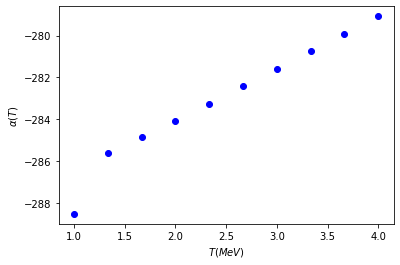

In [4]:


plt.plot(T, alfas, 'bo', )
plt.xlabel(r'$T(MeV)$')
plt.ylabel(r'$\alpha(T)$')
plt.savefig('alfa.pdf')


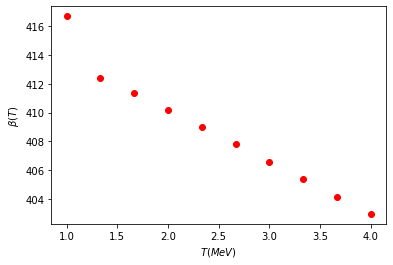

In [5]:
plt.plot(T, betas, 'ro')
plt.xlabel(r'$T(MeV)$')
plt.ylabel(r'$\beta(T)$')
plt.savefig('beta.pdf')

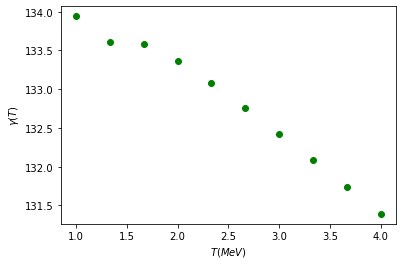

In [6]:
plt.plot(T, gammas, 'go')
plt.xlabel(r'$T(MeV)$')
plt.ylabel(r'$\gamma(T)$')
plt.savefig('gamma.pdf')

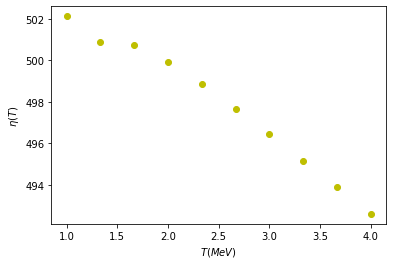

In [7]:
plt.plot(T, etas, 'yo')
plt.xlabel(r'$T(MeV)$')
plt.ylabel(r'$\eta(T)$')
plt.savefig('eta.pdf')

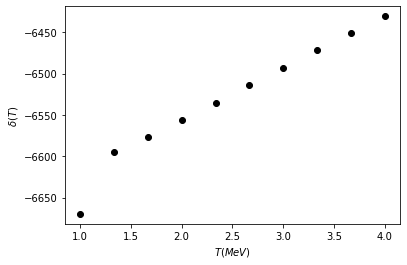

In [8]:
plt.plot(T, deltas, 'ko')
plt.xlabel(r'$T(MeV)$')
plt.ylabel(r'$\delta(T)$')
plt.savefig('delta.pdf')

pandas.core.series.Series

In [33]:
element_file['jp'][2:] = element_file['jp'][2:].str.replace('+', '')
element_file['jp'][2:] = element_file['jp'][2:].str.replace('-', '')
element_file['jp'][2:] = element_file['jp'][2:].str.replace('(', '')
element_file['jp'][2:] = element_file['jp'][2:].str.replace(')', '')

In [34]:
element_file['jp'][2:]

2         5/2
3         1/2
4         1/2
5         3/2
6         5/2
       ...   
69    5/2 7/2
70       25/2
71       27/2
72       29/2
73       31/2
Name: jp, Length: 72, dtype: object

In [35]:
element_file.dropna(subset = ['jp'], inplace=True)

In [36]:
element_file

,Z,N,symbol,energy,unc,jp,half-life operator,half_life,unc.1,unit,...,decay %.1,unc.4,decay.2,decay %.2,unc.5,isospin,magn. dipole,unc.6,elect.quadrupole,unc.7
0,Z,N,symbol,energy,unc,jp,half-life operator,half_life,unc,unit,...,decay %,unc,decay,decay %,unc,isospin,magn. dipole,unc,elect. quadrupole,unc
1,30,33,Zn,0,,3/2-,,38.47,5,m,...,,,,,,,-0.28164,,0.29,
2,30,33,Zn,192.92,0.04,5/2,,0.53,12,ns,...,,,,,,,,,,
3,30,33,Zn,247.84,0.05,1/2,,33,8,ps,...,,,,,,,,,,
4,30,33,Zn,627.11,0.06,1/2,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,30,33,Zn,7200,,5/2 7/2,,,,,...,,,,,,,,,,
70,30,33,Zn,7610.8,1.2,25/2,,,,,...,,,,,,,,,,
71,30,33,Zn,7927,1.3,27/2,,,,,...,,,,,,,,,,
72,30,33,Zn,9096.8,1.6,29/2,,,,,...,,,,,,,,,,


In [132]:
#element_file['jp'][2:] = element_file['jp'][2:].astype('float64')

In [134]:

import fractions


#element_file['jp'][70] = float(fractions.Fraction(element_file['jp'][70]))

In [105]:
#element_file['jp'][70]

12.5

In [108]:
#element_file['jp'][69]

'5/2 7/2'

In [109]:
#len(element_file['jp'][69])

7

In [112]:
#element_file['jp'][69] = element_file['jp'][69][4:]

In [114]:
#element_file['jp'][69] = float(fractions.Fraction(element_file['jp'][69]))

In [115]:
#element_file['jp'][69]

3.5

In [2]:

import fractions
import numpy as np
import pandas as pd
from scipy.integrate import quad

In [192]:
element_file = pd.read_csv('63Zn'+'.csv', names=['Z', 'N', 'symbol', 'energy', 'unc', 'jp', 'half-life operator',
            'half_life', 'unc.1', 'unit', 'half_life[s]', 'unc.2', 'decay',
            'decay %', 'unc.3', 'decay.1', 'decay %.1', 'unc.4', 'decay.2',
            'decay %.2', 'unc.5', 'isospin', 'magn. dipole', 'unc.6',
            'elect.quadrupole ', 'unc.7'], comment=',', header=None)


element_file.dropna(subset = ['jp'], inplace=True) #Hay que considerar este estado base?
element_file.dropna(subset = ['energy'], inplace=True)

element_file['jp'][1:] = element_file['jp'][1:].str.replace('+', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace('-', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace('(', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace(')', '')



In [193]:

def g_t(E, J, T):
    
    suma = 0
    
    for e, j in zip(E, J):
        
        suma += (2*j + 1.)*np.exp(-e/T)
    
    return suma



for i in range(1, len(element_file['jp'][1:])+1):
    
    element_file['jp'][1:][i] = list(element_file['jp'][1:][i])
    
    
    if len(element_file['jp'][1:][i]) == 0 or element_file['jp'][1:][i] == [' ']:
        
        element_file['jp'][1:][i] = 0
        print(type(element_file["jp"][1:][i]))
        print(f'{i} {element_file["jp"][1:][i]}      {element_file["energy"][1:][i]}')
        continue
    
    if ' ' in element_file['jp'][1:][i]:
        
        element_file['jp'][1:][i].remove(' ')
        
        
        while len(element_file['jp'][1:][i]) > 4:
            
            element_file['jp'][1:][i].pop(0)
            
            
    element_file["jp"][1:][i] = ''.join([str(elem) for elem in element_file["jp"][1:][i]])
    element_file["jp"][1:][i] = float(fractions.Fraction(element_file["jp"][1:][i]))
        
    print(type(element_file['jp'][1:][i]))
    print(f'{i} {element_file["jp"][1:][i]} {element_file["energy"][1:][i]}')
    
element_file['jp'] = pd.to_numeric(element_file['jp'], errors='coerce')
element_file['energy'] = pd.to_numeric(element_file['energy'], errors='coerce')


<class 'float'>
1 1.5 0
<class 'float'>
2 2.5 192.92
<class 'float'>
3 0.5 247.84
<class 'float'>
4 0.5 627.11
<class 'float'>
5 1.5 637.07
<class 'float'>
6 2.5 650.1
<class 'float'>
7 1.5 1023.22
<class 'float'>
8 3.5 1063.34
<class 'float'>
9 0.5 1065.28
<class 'float'>
10 3.5 1206.38
<class 'float'>
11 2.5 1284.26
<class 'float'>
12 1.5 1395.44
<class 'float'>
13 11.5 1420
<class 'float'>
14 4.5 1436.26
<class 'float'>
15 3.5 1664.86
<class 'float'>
16 2.5 1691.22
<class 'float'>
17 4.5 1702.96
<class 'float'>
18 13.5 1704
<class 'float'>
19 4.5 1860.84
<class 'float'>
20 11.5 1909.26
<class 'int'>
21 0      1978.4
<class 'float'>
22 4.5 2050.42
<class 'float'>
23 1.5 2158.1
<class 'float'>
24 5.5 2233.3
<class 'int'>
25 0      2249.2
<class 'float'>
26 1.5 2261.53
<class 'float'>
27 3.5 2288.31
<class 'float'>
28 1.5 2291.46
<class 'float'>
29 1.5 2293
<class 'float'>
30 5.5 2318.8
<class 'float'>
31 4.5 2377.86
<class 'int'>
32 0      2403.28
<class 'float'>
33 1.5 2521.14
<class

In [194]:
g_t(element_file['energy'][1:]/1000, element_file['jp'][1:], 3.5)

363.49321038963996

In [307]:
element_file = pd.read_csv('64Zn'+'.csv', names=['Z', 'N', 'symbol', 'energy', 'unc', 'jp', 'half-life operator',
            'half_life', 'unc.1', 'unit', 'half_life[s]', 'unc.2', 'decay',
            'decay %', 'unc.3', 'decay.1', 'decay %.1', 'unc.4', 'decay.2',
            'decay %.2', 'unc.5', 'isospin', 'magn. dipole', 'unc.6', 'elect.quadrupole ', 'unc.7'], comment=',', header=None)


element_file['jp'][1:] = element_file['jp'][1:].str.replace('+', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace('-', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace('(', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace(')', '')


In [298]:
element_file['jp'][1:]

1       0
2       2
3       2
4       0
5       4
       ..
225    23
226    23
227    24
228    25
229    26
Name: jp, Length: 229, dtype: object

In [299]:
element_file['jp'][1:][123]

' '

In [300]:
for i in range(1, len(element_file['jp'][1:])+1):
    
    element_file['jp'][1:][i] = list(element_file['jp'][1:][i])
    
    
    if len(element_file['jp'][1:][i]) == 0 or element_file['jp'][1:][i] == [' ']:
        
        element_file['jp'][1:][i] = 0
        print(type(element_file["jp"][1:][i]))
        print(f'{i} {element_file["jp"][1:][i]}')
        continue
    
    if ' ' in element_file['jp'][1:][i]:
        
        element_file['jp'][1:][i].remove(' ')
        
    if ':' in element_file['jp'][1:][i]:
        
        element_file['jp'][1:][i].remove(':')
        
        
    while len(element_file['jp'][1:][i]) > 2:
            
        element_file['jp'][1:][i].pop(0)
                        
    
    print(type(element_file['jp'][1:][i]))
    print(f'{i} {element_file["jp"][1:][i]}')
    
#element_file['jp'] = pd.to_numeric(element_file['jp'], errors='coerce')
#element_file['energy'] = pd.to_numeric(element_file['energy'], errors='coerce')



<class 'list'>
1 ['0']
<class 'list'>
2 ['2']
<class 'list'>
3 ['2']
<class 'list'>
4 ['0']
<class 'list'>
5 ['4']
<class 'list'>
6 ['0']
<class 'list'>
7 ['4']
<class 'list'>
8 ['2']
<class 'list'>
9 ['3']
<class 'list'>
10 ['3']
<class 'list'>
11 ['2']
<class 'list'>
12 ['1', '2']
<class 'list'>
13 ['4']
<class 'list'>
14 ['3']
<class 'list'>
15 ['1']
<class 'list'>
16 ['2', '3']
<class 'list'>
17 ['3']
<class 'list'>
18 ['0']
<class 'list'>
19 ['1']
<class 'list'>
20 ['1', '5']
<class 'list'>
21 ['2']
<class 'list'>
22 ['4']
<class 'list'>
23 ['1']
<class 'list'>
24 ['1']
<class 'list'>
25 ['3']
<class 'list'>
26 ['1', '5']
<class 'list'>
27 ['1']
<class 'list'>
28 ['1', '2']
<class 'list'>
29 ['2', '3']
<class 'list'>
30 [' ', '6']
<class 'list'>
31 ['2']
<class 'list'>
32 [' ', '6']
<class 'list'>
33 ['E', '3']
<class 'list'>
34 ['4']
<class 'int'>
35 0
<class 'list'>
36 [' ', '4']
<class 'list'>
37 ['1', '2']
<class 'list'>
38 ['E', '4']
<class 'list'>
39 [' ', '6']
<class 'list'

In [257]:
len(element_file['jp'][1:][94])

3

In [217]:
element_file['jp'] = pd.to_numeric(element_file['jp'], errors='coerce')
element_file['energy'] = pd.to_numeric(element_file['energy'], errors='coerce')

In [218]:
element_file['jp'][1:]

1       0.0
2       2.0
3       2.0
4       0.0
5       4.0
       ... 
225    23.0
226    23.0
227    24.0
228    25.0
229    26.0
Name: jp, Length: 229, dtype: float64

In [219]:
g_t(element_file['energy'][1:], element_file['jp'][1:], 1)

nan

In [306]:
a_string = "!1a2;b3c' ''? 4"

numeric_filter = filter(str.isdigit, a_string)
numeric_string = "".join(numeric_filter)

print(numeric_string)
type(numeric_string)

1234


str

In [5]:

element_file = pd.read_csv('64Zn'+'.csv', names=['Z', 'N', 'symbol', 'energy', 'unc', 'jp', 'half-life operator',
            'half_life', 'unc.1', 'unit', 'half_life[s]', 'unc.2', 'decay',
            'decay %', 'unc.3', 'decay.1', 'decay %.1', 'unc.4', 'decay.2',
            'decay %.2', 'unc.5', 'isospin', 'magn. dipole', 'unc.6', 'elect.quadrupole ', 'unc.7'], comment=',', header=None)


element_file.dropna(subset = ['jp'], inplace=True) #Hay que considerar este estado base?
element_file.dropna(subset = ['energy'], inplace=True)


element_file['jp'][1:] = element_file['jp'][1:].str.replace('+', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace('-', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace('(', '')
element_file['jp'][1:] = element_file['jp'][1:].str.replace(')', '')


element_file["jp"][1:] = element_file["jp"][1:].astype(str)



for i in range(1, len(element_file['jp'][1:]) + 1):
    
    #print(f'{i}    {element_file["jp"][1:][i]}')
    
    #numeric_filter = filter(str.isdigit, element_file['jp'][1:][i])
    
    if element_file['jp'][1:][i] == ' ':
        #print(type(element_file['jp'][1:][i]))
        #print(element_file['jp'][1:][i])
        element_file['jp'][1:][i] = 0
        print(type(element_file['jp'][1:][i]))
        print(f'{i} {element_file["jp"][1:][i]}')
        continue
        
    
    if type(element_file['jp'][1:][i]) == str:
        
        numeric_filter = filter(str.isdigit, element_file['jp'][1:][i])
        element_file['jp'][1:][i] = "".join(numeric_filter)
        
        element_file['jp'][1:][i] = list(element_file['jp'][1:][i])
        
        while len(element_file['jp'][1:][i]) > 1:
            
            element_file['jp'][1:][i].pop(0)
            
        element_file['jp'][1:][i] = int(element_file['jp'][1:][i][0])
        
    print(type(element_file['jp'][1:][i]))
    print(f'{i}  {element_file["jp"][1:][i]}')
        #element_file['jp'][1:][i].pop(0)
    
    
     
  
    


<class 'int'>
1  0
<class 'int'>
2  2
<class 'int'>
3  2
<class 'int'>
4  0
<class 'int'>
5  4
<class 'int'>
6  0
<class 'int'>
7  4
<class 'int'>
8  2
<class 'int'>
9  3
<class 'int'>
10  3
<class 'int'>
11  2
<class 'int'>
12  2
<class 'int'>
13  4
<class 'int'>
14  3
<class 'int'>
15  1
<class 'int'>
16  3
<class 'int'>
17  3
<class 'int'>
18  0
<class 'int'>
19  1
<class 'int'>
20  5
<class 'int'>
21  2
<class 'int'>
22  4
<class 'int'>
23  1
<class 'int'>
24  1
<class 'int'>
25  3
<class 'int'>
26  5
<class 'int'>
27  1
<class 'int'>
28  2
<class 'int'>
29  3
<class 'int'>
30  6
<class 'int'>
31  2
<class 'int'>
32  6
<class 'int'>
33  3
<class 'int'>
34  4
<class 'int'>
35 0
<class 'int'>
36  4
<class 'int'>
37  2
<class 'int'>
38  4
<class 'int'>
39  6
<class 'int'>
40  6
<class 'int'>
41  4
<class 'int'>
42  5
<class 'int'>
43 0
<class 'int'>
44  1
<class 'int'>
45  2
<class 'int'>
46  4
<class 'int'>
47  5
<class 'int'>
48  2
<class 'int'>
49  1
<class 'int'>
50  4
<class 'int

In [334]:
print(element_file["jp"][1:])


1       0
2       2
3       2
4       0
5       4
       ..
225    23
226    23
227    24
228    25
229    26
Name: jp, Length: 229, dtype: object


In [3]:
import pandas as pd
import numpy as np
  
  
# Reading the csv file
df_new = pd.read_csv('63Zn.csv')
  
# saving xlsx file
GFG = pd.ExcelWriter('63Zn.xlsx')
df_new.to_excel(GFG, index = True)
  
GFG.save()

1.3678794411714423